## Comparison AI model and CTG readout

In this notebook we want to comapre the results obtained with the AI detectio model, the CTG read out scans and the manually annotated images. Todo

In [1]:
import os
import sys
sys.path.append(os.path.dirname(os.path.dirname(os.getcwd())))
import pickle

import os
import torch
from torch.utils.data import DataLoader
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from scipy.stats import pearsonr, spearmanr

from src.utils.data_utils import run_length_encode
from src.model.dataset import InferenceMaskRCNNDataset, MaskRCNNDataset
from src.model.engine import FitterMaskRCNN
from src.model.model import maskRCNNModel
from src.utils.data_utils import masks_to_area, mask_to_eccentricity, masks_to_volume, masks_to_volume_2, masks_to_diameter
from src.utils.utils import load_finetuned_weights, load_pretrained_weights

dataset_path="../dataset/complete_dataset"
CTG_files = []
confidence = [0, 0.5, 0.75, 0.9]


/Users/francesco/miniconda3/envs/colorec/lib/python3.12/site-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.8' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
# run the inference on the dataset
dataset_inference = InferenceMaskRCNNDataset(dataset_path)
loader = DataLoader(dataset_inference, batch_size=4, shuffle=False, collate_fn = lambda x: tuple(zip(*x)))
print(f"Loaded {len(dataset_inference)} images from {dataset_inference}")
# Load model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = maskRCNNModel()
weights = load_finetuned_weights(device)
model.load_state_dict(weights)
model.to(device)

engine = FitterMaskRCNN()
predictions_path = "/Volumes/Extreme_SSD/Gastrointestinal_voucher/finetune_predictions.pkl"
if os.path.exists(predictions_path):
    predictions = pickle.load(open(predictions_path, "rb"))
else:
    predictions = engine.inference(model, loader, 0.0) #TODO: make threshold configurable
    with open(predictions_path, "wb") as f:
        pickle.dump(predictions, f)

Loaded 100 images from <src.model.dataset.InferenceMaskRCNNDataset object at 0x3131b3e30>


/Users/francesco/Documents/Work/Colorectal-Cancer-Organoids-Detection/src/utils/utils.py:173: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_wei

In [3]:
# run the inference on the dataset with the base model
# Load model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_pretr = maskRCNNModel()
weights = load_pretrained_weights(device)
model_pretr.load_state_dict(weights)
model_pretr.to(device)

engine = FitterMaskRCNN()
predictions_path = "/Volumes/Extreme_SSD/Gastrointestinal_voucher/pretrain_predictions.pkl"
if os.path.exists(predictions_path):
    predictions_pretr = pickle.load(open(predictions_path, "rb"))
else:
    predictions_pretr = engine.inference(model_pretr, loader, 0.0) #TODO: make threshold configurable
    with open(predictions_path, "wb") as f:
        pickle.dump(predictions_pretr, f)

/Users/francesco/Documents/Work/Colorectal-Cancer-Organoids-Detection/src/utils/utils.py:156: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_wei

In [4]:
# get the ground truth
dataset = MaskRCNNDataset(dataset_path, datatype="eval")
ground_truths = []
for _, ground_truth in dataset:
    ground_truths.append(ground_truth)

/Users/francesco/miniconda3/envs/colorec/lib/python3.12/site-packages/albumentations/core/composition.py:250: UserWarning: Got processor for bboxes, but no transform to process it.
  self._set_keys()


In [5]:
# read CTG files
columns = ["ID", "well", "CTG"]
CTG_D223_CRTL = pd.read_csv("CTG_reatout/15042024_TM_M3_DTP1_D223_CTRL.txt", names=columns, sep="\t")
CTG_D284_DMSO = pd.read_csv("CTG_reatout/15042024_TM_M3_DTP1_D284_DMSO.txt", names=columns, sep="\t")
CTG_D284_TREAT = pd.read_csv("CTG_reatout/15042024_TM_M3_DTP1_D284_TREAT.txt", names=columns, sep="\t")

In [6]:
def process_predictions(predictions, ground_truths, images_paths):
    processed_predictions = {}
    for c in confidence:
        df = pd.DataFrame(columns=["image_path", "experiment", "predicted_area", "gt_area", "predicted_count", "gt_count", "predicted_volume", "gt_volume", "predicted_volume_2", "gt_volume_2", "predicted_diameter", "gt_diameter", "CTG"])
        for i, (image_path, prediction, ground_truth) in enumerate(zip(images_paths, predictions, ground_truths)):
            # get CTG readout value
            if "D223_CTRL" in image_path:
                ctg_df = CTG_D223_CRTL
                exp = "D223_CTRL"
            elif "D284_DMSO" in image_path:
                ctg_df = CTG_D284_DMSO
                exp = "D284_DMSO"
            elif "D284_TREAT" in image_path:
                ctg_df = CTG_D284_TREAT
                exp = "D284_TREAT"
            else:
                # image belongs to an experiment without CTG readout
                print(f"CTG readout not found for {image_path}")
                continue
            # get the well name
            well_nr = int(os.path.basename(image_path).split("_")[1][2:])
            well_row = chr(ord('A') + (well_nr-1)//24)
            well_col = ((well_nr-1) % 24) + 1
            well_name = f"{well_row}{well_col:02d}"
            # print(f"well nr: {well_nr}, well name: {well_name}")
            # get the CTG value
            ctg_value = ctg_df[ctg_df["well"] == well_name]["CTG"].values[0]
            # get the predicted areas
            prediction_area = 0.0
            prediction_volume = 0.0
            prediction_volume_2 = 0.0
            prediction_diam = 0.0
            for predicted_mask, score in zip(prediction["masks"], prediction["scores"]):
                # check if the score is above the threshold
                if score < c:
                    continue
                # get the predicted areas
                prediction_area += masks_to_area(predicted_mask)
                prediction_volume += masks_to_volume(predicted_mask)
                prediction_diam += masks_to_volume_2(predicted_mask)
                prediction_volume_2 += masks_to_volume_2(predicted_mask)

            # get the ground truth areas
            ground_truth_area = 0.0
            ground_truth_volume = 0.0
            ground_truth_volume_2 = 0.0
            ground_truth_diam = 0.0
            for gt_mask in ground_truth["masks"]:
                # get the ground truth areas
                ground_truth_area += masks_to_area(gt_mask)
                ground_truth_volume += masks_to_volume(gt_mask)
                ground_truth_volume_2 += masks_to_volume_2(gt_mask)
                ground_truth_diam += masks_to_diameter(gt_mask)
            prediction_count = len(prediction["masks"])
            gt_count = len(ground_truth["masks"])
            df.loc[i] = [image_path, exp, prediction_area, ground_truth_area, prediction_count, gt_count, prediction_volume, ground_truth_volume, prediction_volume_2, ground_truth_volume_2, prediction_diam, ground_truth_diam,ctg_value]

        print("Number of images: ", len(df))    
        df["predicted_area_norm"] = df["predicted_area"]/df["predicted_area"].max()
        df["gt_area_norm"] = df["gt_area"]/df["gt_area"].max()
        df["CTG_norm"] = df["CTG"]/df["CTG"].max()  
        processed_predictions[c] = df
    return processed_predictions

In [7]:
processed_predictions_finetuned = process_predictions(predictions, ground_truths, dataset_inference.images_paths)
processed_predictions_pretrained = process_predictions(predictions_pretr, ground_truths, dataset_inference.images_paths)

CTG readout not found for ../dataset/complete_dataset/images/D131_CTRL_d9/Bortezomib/10x_XY291_Z001_CH4.tif
CTG readout not found for ../dataset/complete_dataset/images/D131_CTRL_d9/Bortezomib/10x_XY147_Z001_CH4.tif
CTG readout not found for ../dataset/complete_dataset/images/D131_CTRL_d9/Bortezomib/10x_XY300_Z001_CH4.tif
CTG readout not found for ../dataset/complete_dataset/images/D131_CTRL_d9/Bortezomib/10x_XY306_Z001_CH4.tif
CTG readout not found for ../dataset/complete_dataset/images/D131_CTRL_d9/Bortezomib/10x_XY295_Z001_CH4.tif
CTG readout not found for ../dataset/complete_dataset/images/D131_CTRL_d9/DMSO/10x_XY73_Z001_CH4.tif
CTG readout not found for ../dataset/complete_dataset/images/D131_CTRL_d9/DMSO/10x_XY265_Z001_CH4.tif
CTG readout not found for ../dataset/complete_dataset/images/D131_CTRL_d9/DMSO/10x_XY169_Z001_CH4.tif
CTG readout not found for ../dataset/complete_dataset/images/D131_CTRL_d9/DMSO/10x_XY373_Z001_CH4.tif
CTG readout not found for ../dataset/complete_dataset

In [8]:
    
def plot_predictions(processed_predictions):
    corr = pd.DataFrame(
        columns=[
            "confidence", 
            "pearson_gt_ctg_area", 
            "spearman_gt_ctg_area", 
            "pearson_pred_ctg_area", 
            "spearman_pred_ctg_area", 
            "pearson_gt_ctg_volume", 
            "spearman_gt_ctg_volume",
            "pearson_pred_ctg_volume",
            "spearman_pred_ctg_volume",
            "pearson_pred_gt", 
            "spearman_pred_gt"
        ], 
        index=list(range(len(confidence))))
    p = corr.copy(deep=True)
    fig, axes = plt.subplots(len(confidence), 8, figsize=(40, 5*len(confidence)))
    fig.suptitle("Finetuned Model")
    for i, c in enumerate(confidence):
        # scatterplot of ground truth area vs CTG
        df = processed_predictions[c]
        axes[i, 0].scatter(df["gt_area"], df["CTG"], label="Ground Truth Area")
        axes[i, 0].set_xlabel("Ground Truth Area")
        axes[i, 0].set_ylabel("CTG")
        axes[i, 0].set_title("Ground Truth Area vs CTG")

        # scatterplot of predicted area vs CTG
        axes[i, 1].scatter(df["predicted_area"], df["CTG"], label="Predicted Area")
        axes[i, 1].set_xlabel("Predicted Area")
        axes[i, 1].set_ylabel("CTG")
        axes[i, 1].set_title("Predicted Area vs CTG")

        # scatterplot of ground truth volume vs CTG
        axes[i, 2].scatter(df["gt_volume"], df["CTG"], label="Ground Truth Volume")
        axes[i, 2].set_xlabel("Ground Truth Volume")
        axes[i, 2].set_ylabel("CTG")
        axes[i, 2].set_title("Ground Truth Volume vs CTG")
        # scatterplot of predicted volume vs CTG
        axes[i, 3].scatter(df["predicted_volume"], df["CTG"], label="Predicted Volume")
        axes[i, 3].set_xlabel("Predicted Volume")
        axes[i, 3].set_ylabel("CTG")
        axes[i, 3].set_title("Predicted Volume vs CTG")

        # scatterplot of ground truth count vs CTG
        axes[i, 4].scatter(df["gt_count"], df["CTG"], label="Ground Truth Count")
        axes[i, 4].set_xlabel("Ground Truth Count")
        axes[i, 4].set_ylabel("CTG")
        axes[i, 4].set_title("Ground Truth Count vs CTG")

        # scatterplot of predicted count vs CTG
        axes[i, 5].scatter(df["predicted_count"], df["CTG"], label="Predicted Count")
        axes[i, 5].set_xlabel("Predicted Count")
        axes[i, 5].set_ylabel("CTG")
        axes[i, 5].set_title("Predicted Count vs CTG")



        # scatterplot of predicted area vs ground truth area
        axes[i, 6].scatter(df["predicted_area"], df["gt_area"], label="Predicted Area")
        axes[i, 6].set_xlabel("Predicted Area")
        axes[i, 6].set_ylabel("Ground Truth Area")
        axes[i, 6].set_title("Predicted Area vs Ground Truth Area")
        axes[i, 6].plot([0, df["predicted_area"].max()*1.1], [0, df["predicted_area"].max()*1.1], color='red', linestyle='--')


        # scatterplot of predicted count vs ground truth count
        axes[i, 7].scatter(df["predicted_count"], df["gt_count"], label="Predicted Count")
        axes[i, 7].set_xlabel("Predicted Count")
        axes[i, 7].set_ylabel("Ground Truth Count")
        axes[i, 7].set_title("Predicted Count vs Ground Truth Count")

        axes[i, 7].plot([0, df["predicted_count"].max()*1.1], [0, df["predicted_count"].max()*1.1], color='red', linestyle='--')


        # calculate the correlation coefficients
        pearson_corr_gt = pearsonr(df["gt_area"], df["CTG"])
        spearman_corr_gt = spearmanr(df["gt_area"], df["CTG"])
        pearson_corr_pred = pearsonr(df["predicted_area"], df["CTG"])
        spearman_corr_pred = spearmanr(df["predicted_area"], df["CTG"])
        pearson_corr_gt_volume = pearsonr(df["gt_volume"], df["CTG"])
        spearman_corr_gt_volume = spearmanr(df["gt_volume"], df["CTG"])
        pearson_corr_pred_volume = pearsonr(df["predicted_volume"], df["CTG"])
        spearman_corr_pred_volume = spearmanr(df["predicted_volume"], df["CTG"])
        pearson_corr_pred_gt = pearsonr(df["predicted_area"], df["gt_area"])
        spearman_corr_pred_gt = spearmanr(df["predicted_area"], df["gt_area"])
        corr.loc[i] = [c, pearson_corr_gt[0], spearman_corr_gt[0], pearson_corr_pred[0], spearman_corr_pred[0], pearson_corr_gt_volume[0], spearman_corr_gt_volume[0], pearson_corr_pred_volume[0], spearman_corr_pred_volume[0], pearson_corr_pred_gt[0], spearman_corr_pred_gt[0]]
        p.loc[i] = [c, pearson_corr_gt[1], spearman_corr_gt[1], pearson_corr_pred[1], spearman_corr_pred[1], pearson_corr_gt_volume[1], spearman_corr_gt_volume[1], pearson_corr_pred_volume[1], spearman_corr_pred_volume[1], pearson_corr_pred_gt[1], spearman_corr_pred_gt[1]]
        # print(f"Pearson correlation coefficient (Ground Truth Area vs CTG): {pearson_corr_gt[0]}, p-value: {pearson_corr_gt[1]}")
        # print(f"Spearman correlation coefficient (Ground Truth Area vs CTG): {spearman_corr_gt[0]}, p-value: {spearman_corr_gt[1]}")
        # print(f"Pearson correlation coefficient (Predicted Area vs CTG): {pearson_corr_pred[0]}, p-value: {pearson_corr_pred[1]}")
        # print(f"Spearman correlation coefficient (Predicted Area vs CTG): {spearman_corr_pred[0]}, p-value: {spearman_corr_pred[1]}")
        # print(f"Pearson correlation coefficient (Predicted Area vs Ground Truth Area): {pearson_corr_pred_gt[0]}, p-value: {pearson_corr_pred_gt[1]}")
        # print(f"Spearman correlation coefficient (Predicted Area vs Ground Truth Area): {spearman_corr_pred_gt[0]}, p-value: {spearman_corr_pred_gt[1]}")

    plt.show()
    display(corr)
    print("p-values")
    display(p)


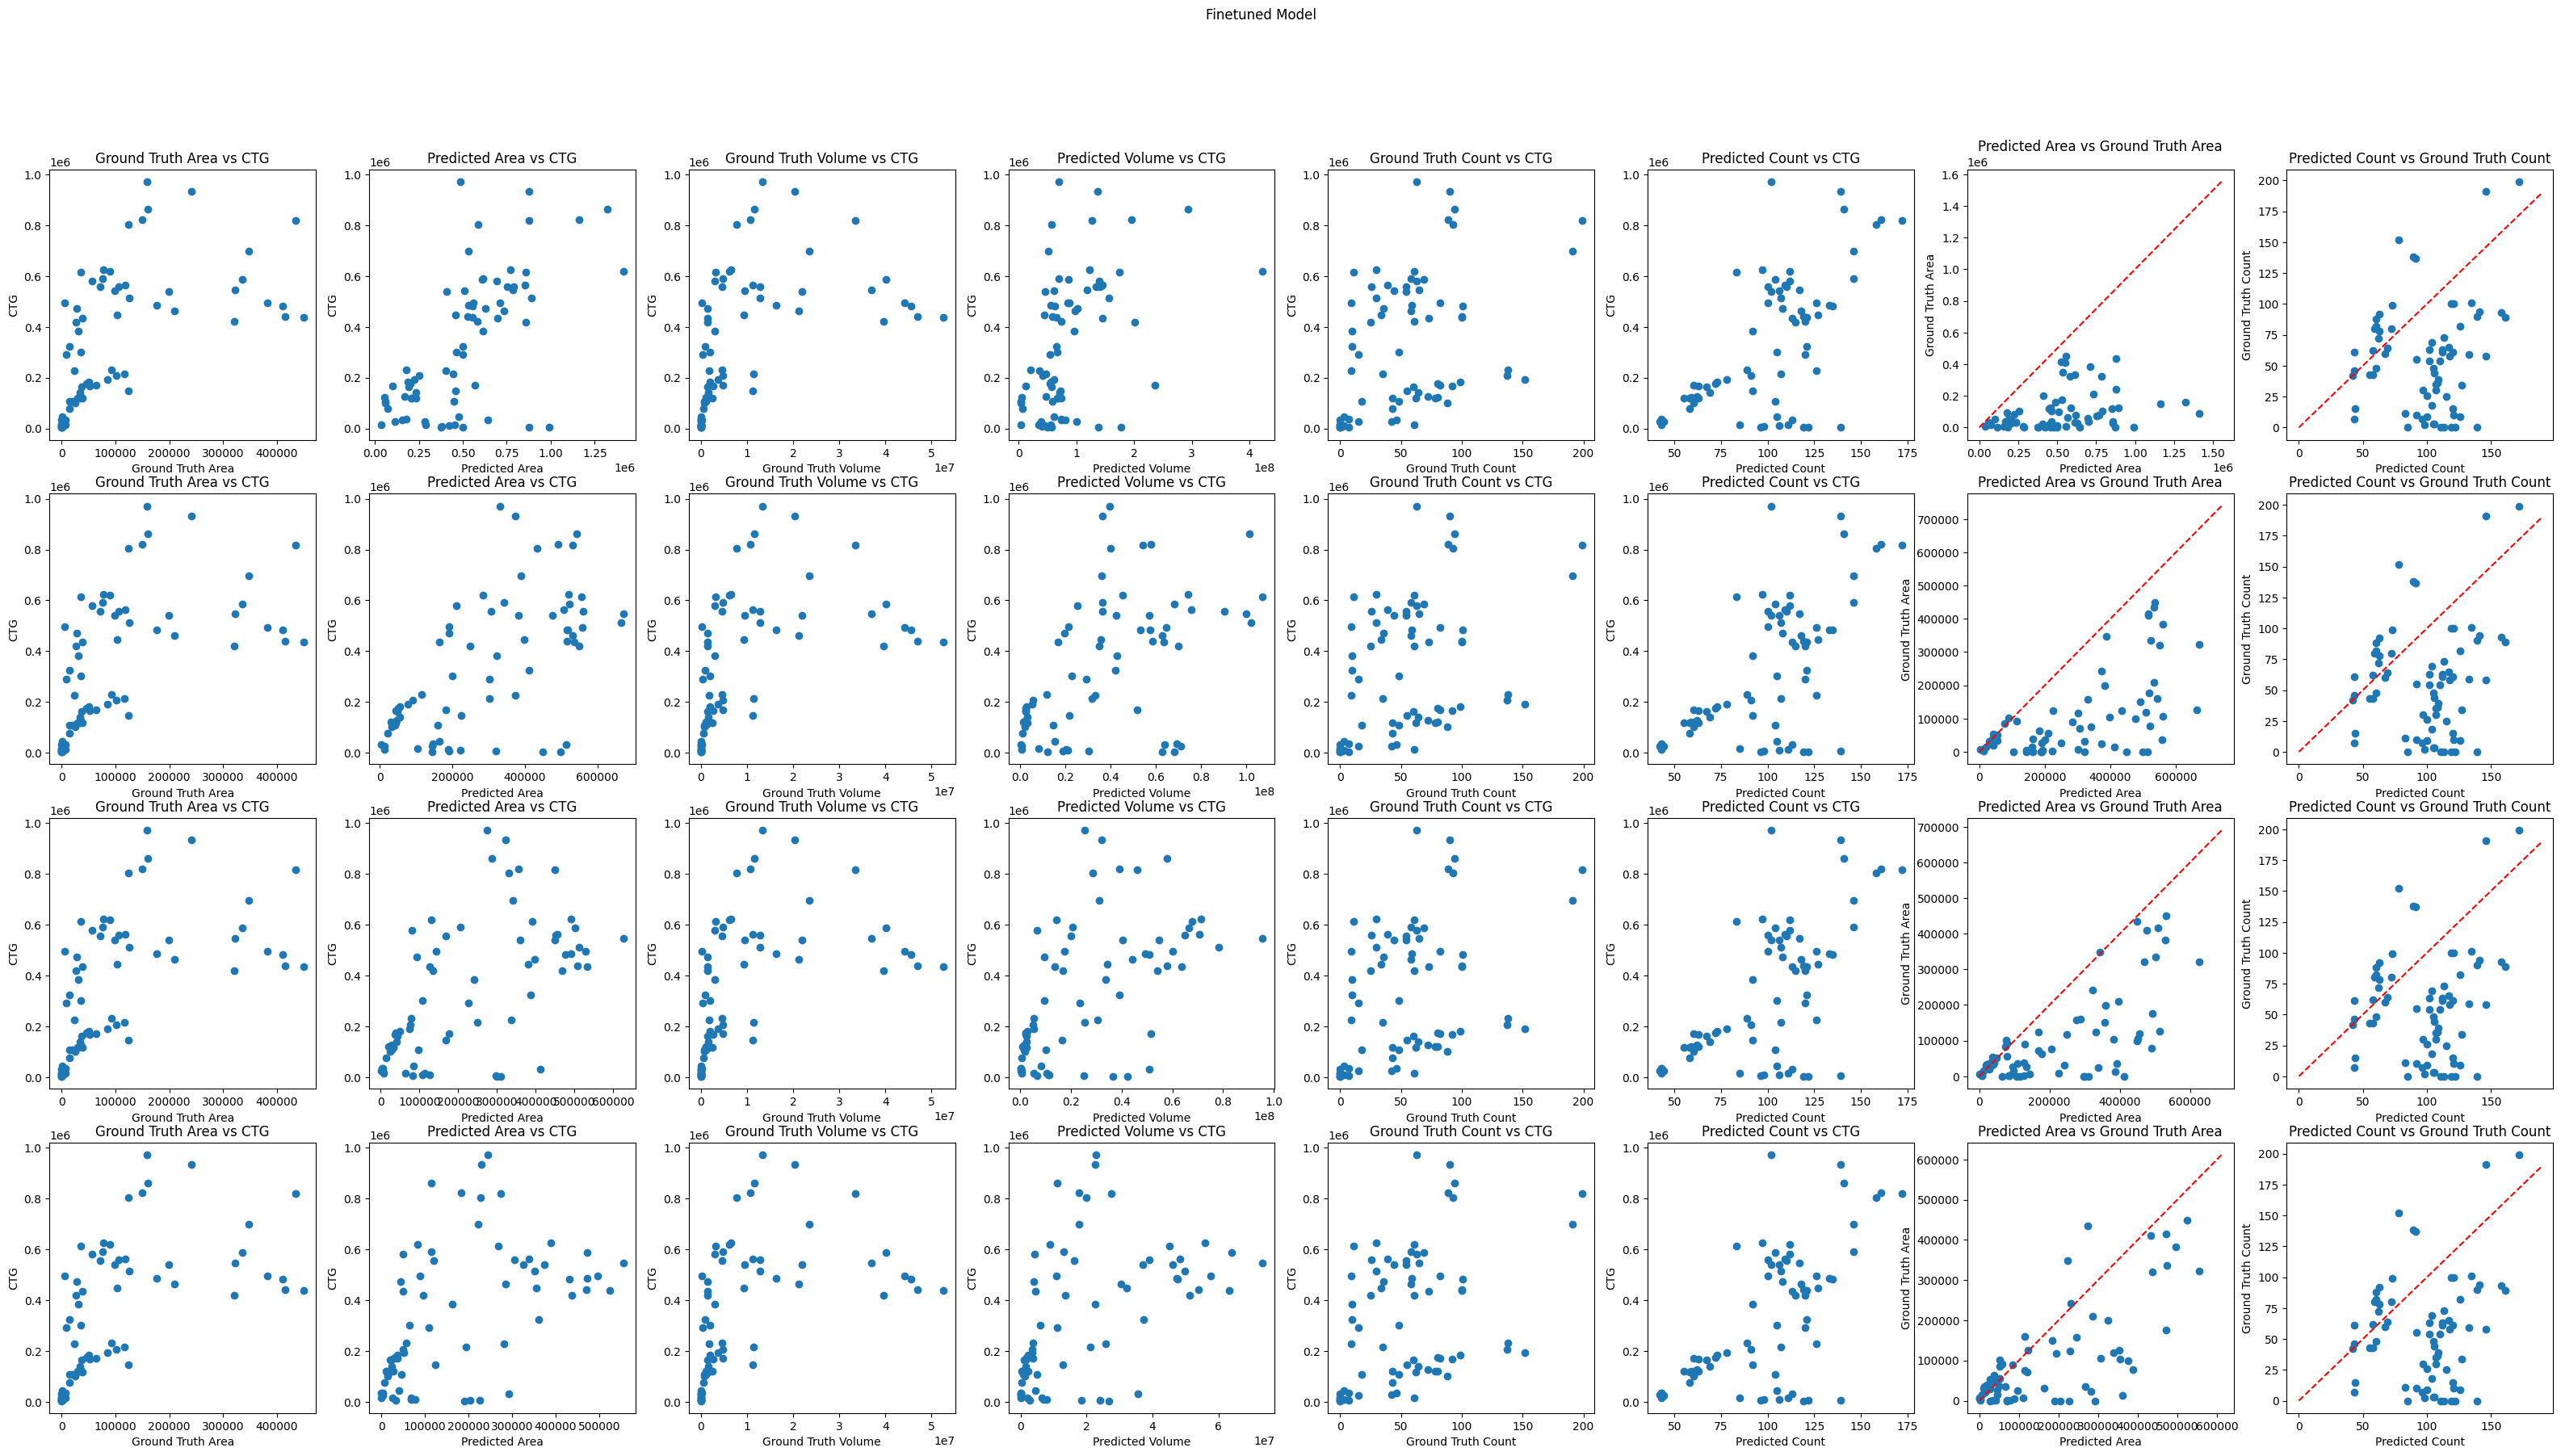

confidence pearson_gt_ctg_area spearman_gt_ctg_area pearson_pred_ctg_area  \
0          0            0.592748             0.786269              0.653938   
1        0.5            0.592748             0.786269              0.636369   
2       0.75            0.592748             0.786269              0.604558   
3        0.9            0.592748             0.786269              0.532289   

  spearman_pred_ctg_area pearson_gt_ctg_volume spearman_gt_ctg_volume  \
0               0.622484              0.506859                0.80441   
1               0.620265              0.506859                0.80441   
2               0.608785              0.506859                0.80441   
3               0.602053              0.506859                0.80441   

  pearson_pred_ctg_volume spearman_pred_ctg_volume pearson_pred_gt  \
0                 0.45015                 0.458615        0.324773   
1                0.530537                 0.528523         0.61697   
2                0.570015                 0.607209        0.699386   
3                0.507373                 0.583242        0.731119   

  spearman_pred_gt  
0         0.374776  
1         0.547199  
2         0.592086  
3         0.595564

p-values


confidence pearson_gt_ctg_area spearman_gt_ctg_area pearson_pred_ctg_area  \
0          0                 0.0                  0.0                   0.0   
1        0.5                 0.0                  0.0                   0.0   
2       0.75                 0.0                  0.0                   0.0   
3        0.9                 0.0                  0.0              0.000001   

  spearman_pred_ctg_area pearson_gt_ctg_volume spearman_gt_ctg_volume  \
0                    0.0              0.000006                    0.0   
1                    0.0              0.000006                    0.0   
2                    0.0              0.000006                    0.0   
3                    0.0              0.000006                    0.0   

  pearson_pred_ctg_volume spearman_pred_ctg_volume pearson_pred_gt  \
0                0.000073                 0.000051        0.005379   
1                0.000002                 0.000002             0.0   
2                     0.0                      0.0             0.0   
3                0.000005                      0.0             0.0   

  spearman_pred_gt  
0         0.001181  
1         0.000001  
2              0.0  
3              0.0

In [9]:
plot_predictions(processed_predictions_pretrained)

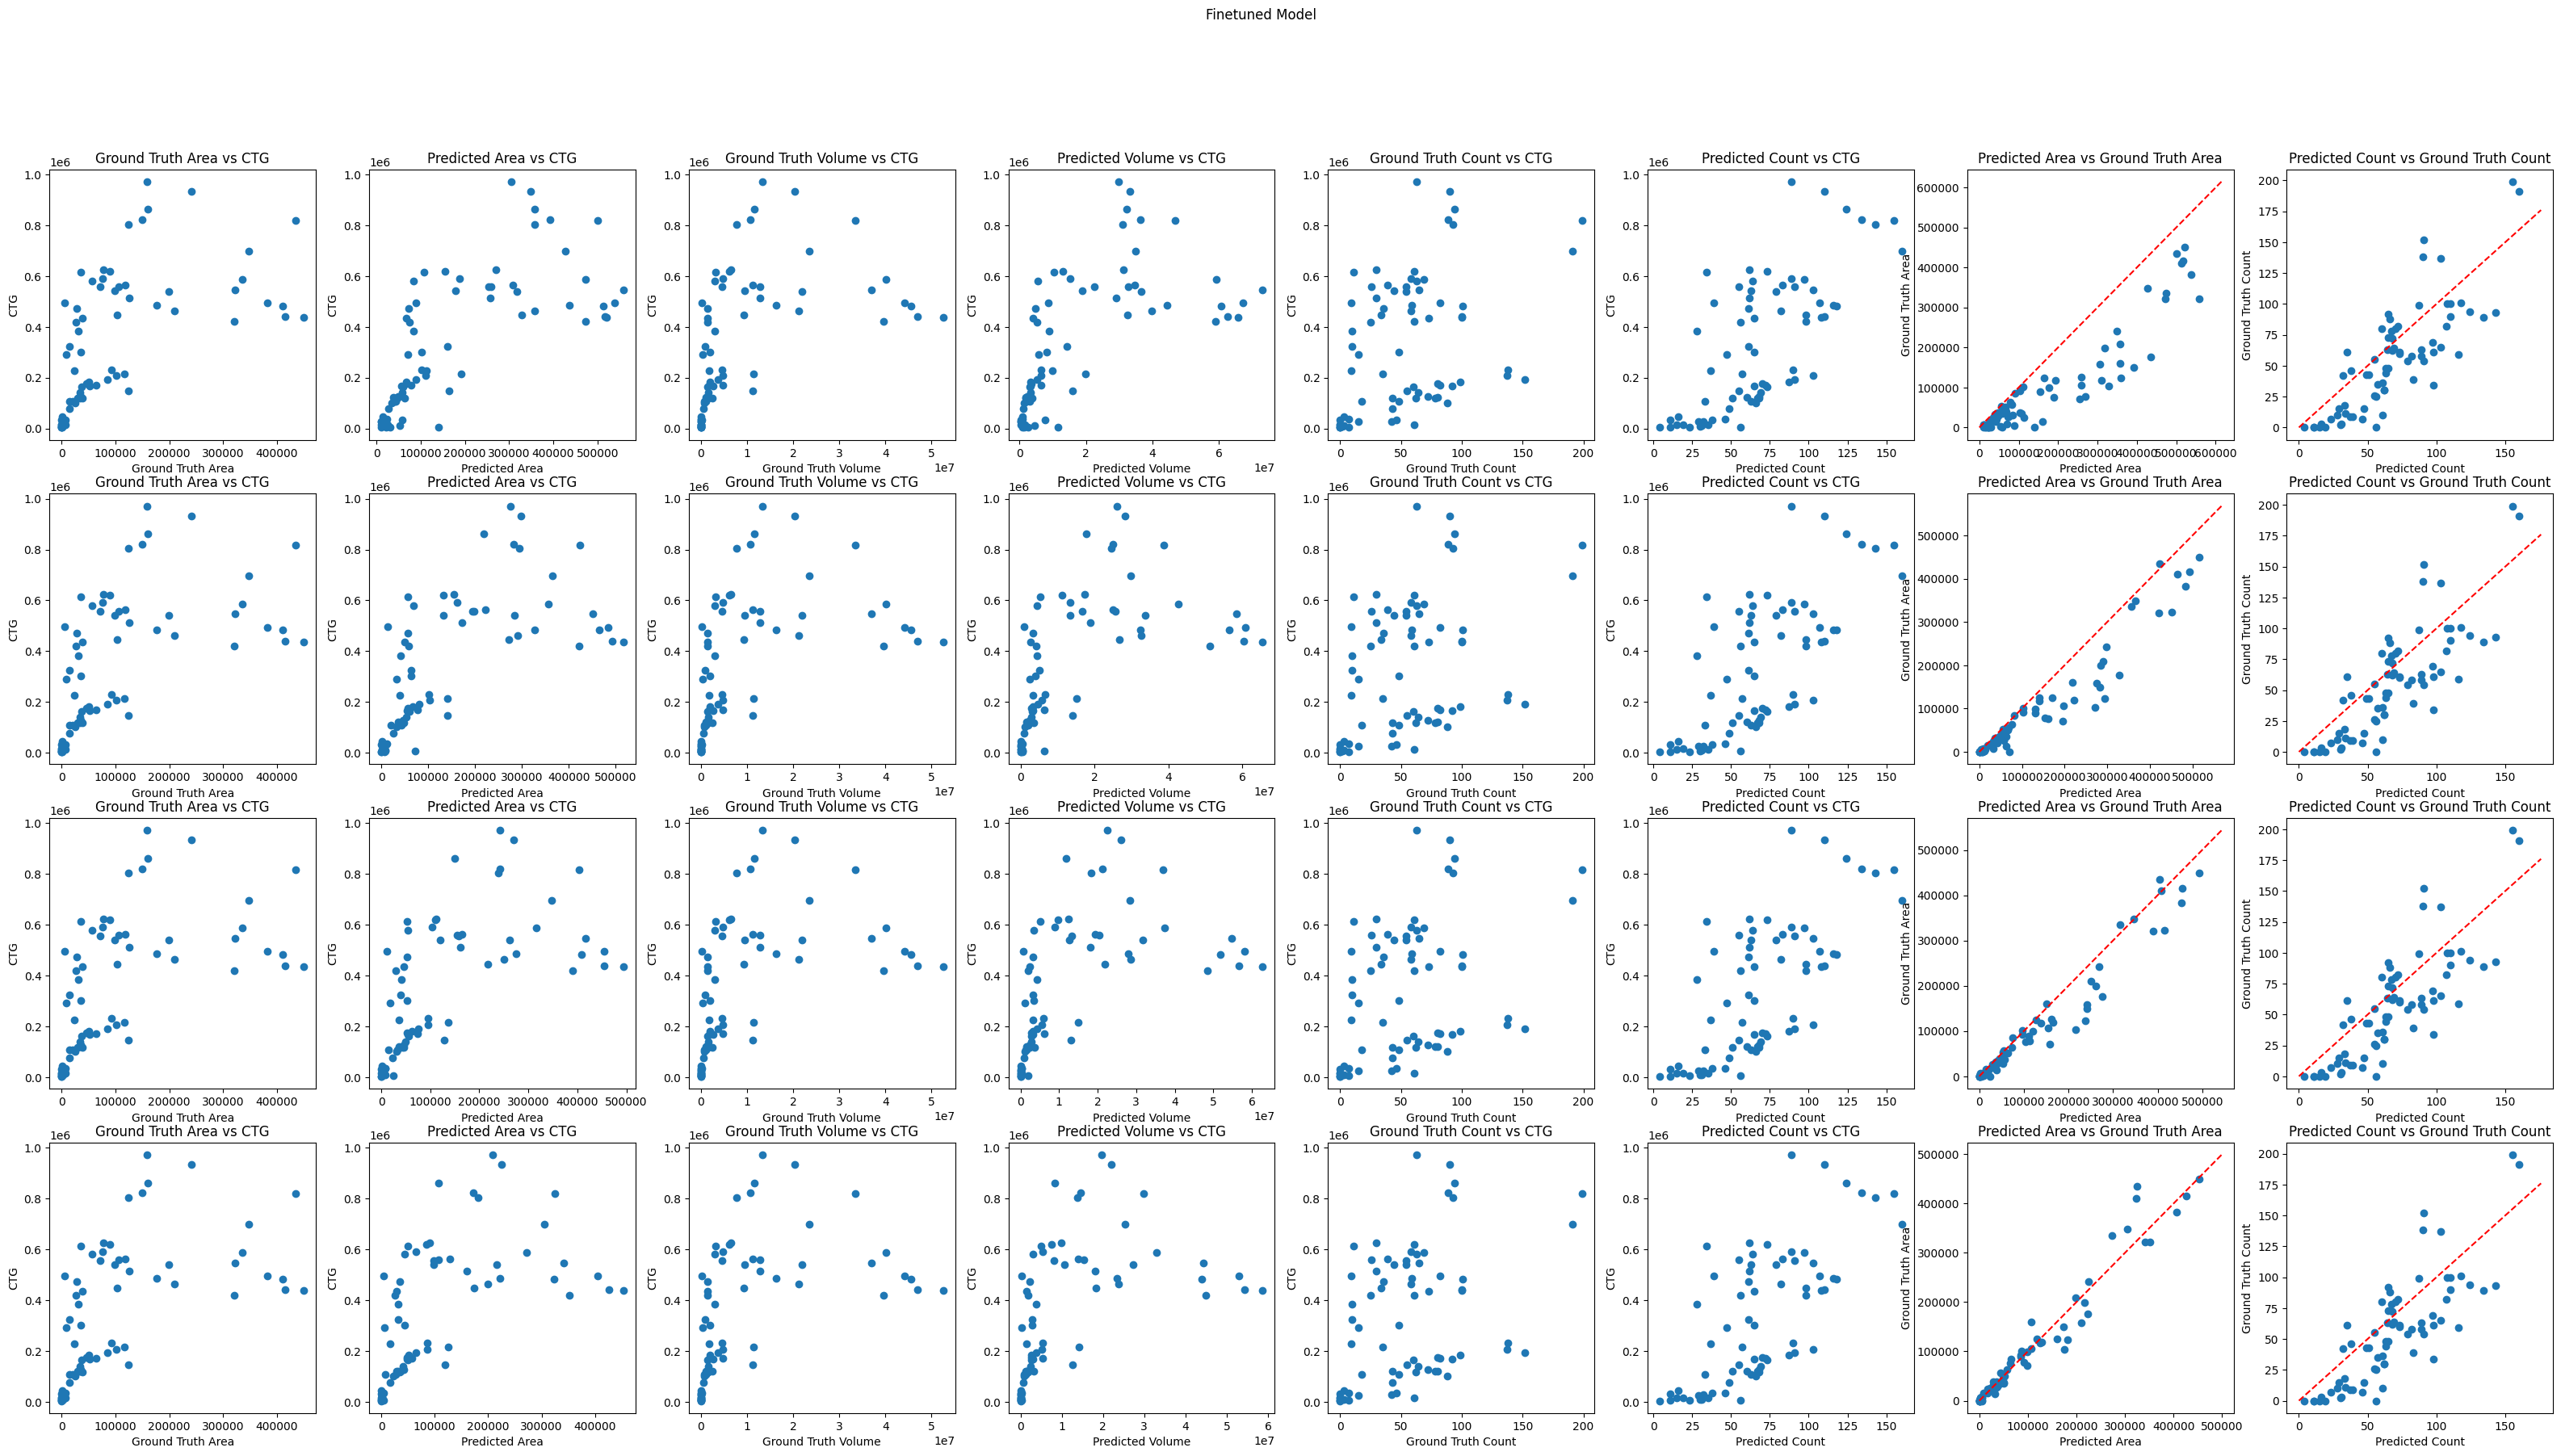

confidence pearson_gt_ctg_area spearman_gt_ctg_area pearson_pred_ctg_area  \
0          0            0.592748             0.786269              0.729903   
1        0.5            0.592748             0.786269              0.681744   
2       0.75            0.592748             0.786269              0.649037   
3        0.9            0.592748             0.786269               0.60929   

  spearman_pred_ctg_area pearson_gt_ctg_volume spearman_gt_ctg_volume  \
0               0.832304              0.506859                0.80441   
1               0.805705              0.506859                0.80441   
2               0.807448              0.506859                0.80441   
3               0.791722              0.506859                0.80441   

  pearson_pred_ctg_volume spearman_pred_ctg_volume pearson_pred_gt  \
0                0.652728                 0.801563         0.92621   
1                0.597807                 0.804258        0.960605   
2                0.564344                 0.810535        0.974896   
3                0.524141                  0.80211        0.976553   

  spearman_pred_gt  
0         0.885419  
1         0.950842  
2         0.981206  
3         0.982155

p-values


confidence pearson_gt_ctg_area spearman_gt_ctg_area pearson_pred_ctg_area  \
0          0                 0.0                  0.0                   0.0   
1        0.5                 0.0                  0.0                   0.0   
2       0.75                 0.0                  0.0                   0.0   
3        0.9                 0.0                  0.0                   0.0   

  spearman_pred_ctg_area pearson_gt_ctg_volume spearman_gt_ctg_volume  \
0                    0.0              0.000006                    0.0   
1                    0.0              0.000006                    0.0   
2                    0.0              0.000006                    0.0   
3                    0.0              0.000006                    0.0   

  pearson_pred_ctg_volume spearman_pred_ctg_volume pearson_pred_gt  \
0                     0.0                      0.0             0.0   
1                     0.0                      0.0             0.0   
2                     0.0                      0.0             0.0   
3                0.000002                      0.0             0.0   

  spearman_pred_gt  
0              0.0  
1              0.0  
2              0.0  
3              0.0

In [10]:
plot_predictions(processed_predictions_finetuned)



## Organoid line-wise correlation plots

We futher plot the plots above for eahc organoid line separately. For calrity we only plot the hte best confidence threshold:  

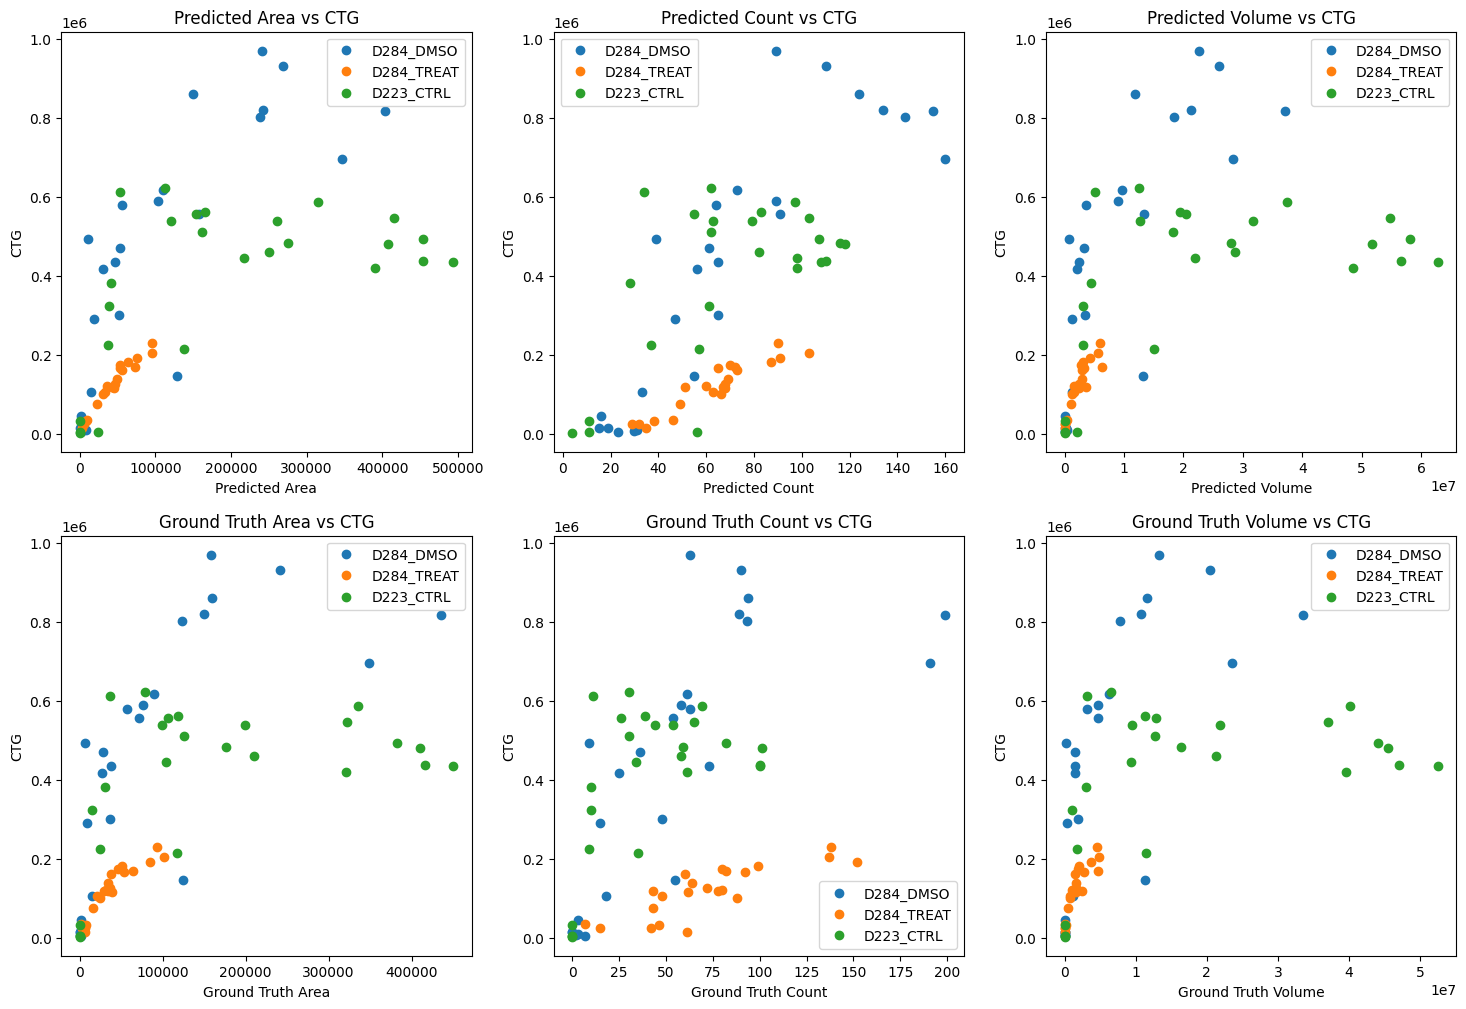

spearmanr_D284_DMSO  spearmanr_D284_TREAT  spearmanr_D223_CTRL  \
pred_area                     0.89                  0.98                 0.44   
pred_count                    0.89                  0.93                 0.38   
pred_volume_2                 0.88                  0.91                 0.44   
gt_area                       0.88                  0.94                 0.44   
gt_count                      0.87                  0.82                 0.45   
gt_volume                     0.87                  0.92                 0.44   

               pearsonr_D284_DMSO  pearsonr_D284_TREAT  pearsonr_D223_CTRL  
pred_area                    0.80                 0.97                0.53  
pred_count                   0.86                 0.94                0.62  
pred_volume_2                0.77                 0.90                0.50  
gt_area                      0.69                 0.92                0.48  
gt_count                     0.73                 0.82                0.55  
gt_volume                    0.68                 0.87                0.46

In [19]:
# simple example with pred area and ctg
c = 0.75
df = processed_predictions_finetuned[c]
correlation = pd.DataFrame(columns=["spearmanr_D284_DMSO", "spearmanr_D284_TREAT", "spearmanr_D223_CTRL", "pearsonr_D284_DMSO", "pearsonr_D284_TREAT", "pearsonr_D223_CTRL"])

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
# Plotting the predicted area vs CTG for each experiment
area_1 = df[df["experiment"] == "D284_DMSO"]["predicted_area"]
ctg_1 = df[df["experiment"] == "D284_DMSO"]["CTG"]
area_2 = df[df["experiment"] == "D284_TREAT"]["predicted_area"]
ctg_2 = df[df["experiment"] == "D284_TREAT"]["CTG"]
area_3 = df[df["experiment"] == "D223_CTRL"]["predicted_area"]
ctg_3 = df[df["experiment"] == "D223_CTRL"]["CTG"]
correlation.loc["pred_area"] = [spearmanr(area_1, ctg_1)[0], spearmanr(area_2, ctg_2)[0], spearmanr(area_3, ctg_3)[0], 
                            pearsonr(area_1, ctg_1)[0], pearsonr(area_2, ctg_2)[0], pearsonr(area_3, ctg_3)[0]]

axes[0, 0].plot(area_1, ctg_1, 'o', label="D284_DMSO")
axes[0, 0].plot(area_2, ctg_2, 'o', label="D284_TREAT")
axes[0, 0].plot(area_3, ctg_3, 'o', label="D223_CTRL")
axes[0, 0].set_xlabel("Predicted Area")
axes[0, 0].set_ylabel("CTG")
axes[0, 0].set_title("Predicted Area vs CTG")
axes[0, 0].legend()

# Plotting the predicted count vs CTG for each experiment with the pretrained model
count_1 = df[df["experiment"] == "D284_DMSO"]["predicted_count"]
ctg_1 = df[df["experiment"] == "D284_DMSO"]["CTG"]
count_2 = df[df["experiment"] == "D284_TREAT"]["predicted_count"]
ctg_2 = df[df["experiment"] == "D284_TREAT"]["CTG"]
count_3 = df[df["experiment"] == "D223_CTRL"]["predicted_count"]
ctg_3 = df[df["experiment"] == "D223_CTRL"]["CTG"]
correlation.loc["pred_count"] = [spearmanr(count_1, ctg_1)[0], spearmanr(count_2, ctg_2)[0], spearmanr(count_3, ctg_3)[0], 
                            pearsonr(count_1, ctg_1)[0], pearsonr(count_2, ctg_2)[0], pearsonr(count_3, ctg_3)[0]]

axes[0, 1].plot(count_1, ctg_1, 'o', label="D284_DMSO")
axes[0, 1].plot(count_2, ctg_2, 'o', label="D284_TREAT")
axes[0, 1].plot(count_3, ctg_3, 'o', label="D223_CTRL")
axes[0, 1].set_xlabel("Predicted Count")
axes[0, 1].set_ylabel("CTG")
axes[0, 1].set_title("Predicted Count vs CTG")
axes[0, 1].legend()


# Plotting the predicted volume vs CTG for each experiment with the pretrained model
volume_1 = df[df["experiment"] == "D284_DMSO"]["predicted_volume"]
ctg_1 = df[df["experiment"] == "D284_DMSO"]["CTG"]
volume_2 = df[df["experiment"] == "D284_TREAT"]["predicted_volume"]
ctg_2 = df[df["experiment"] == "D284_TREAT"]["CTG"]
volume_3 = df[df["experiment"] == "D223_CTRL"]["predicted_volume"]
ctg_3 = df[df["experiment"] == "D223_CTRL"]["CTG"]
correlation.loc["pred_volume_2"] = [spearmanr(volume_1, ctg_1)[0], spearmanr(volume_2, ctg_2)[0], spearmanr(volume_3, ctg_3)[0], 
                            pearsonr(volume_1, ctg_1)[0], pearsonr(volume_2, ctg_2)[0], pearsonr(volume_3, ctg_3)[0]]

axes[0, 2].plot(volume_1, ctg_1, 'o', label="D284_DMSO")
axes[0, 2].plot(volume_2, ctg_2, 'o', label="D284_TREAT")
axes[0, 2].plot(volume_3, ctg_3, 'o', label="D223_CTRL")
axes[0, 2].set_xlabel("Predicted Volume")
axes[0, 2].set_ylabel("CTG")
axes[0, 2].set_title("Predicted Volume vs CTG")
axes[0, 2].legend()

# # Plotting the predicted diameter vs CTG for each experiment with the pretrained model
# volume_1 = df[df["experiment"] == "D284_DMSO"]["predicted_diameter"]
# ctg_1 = df[df["experiment"] == "D284_DMSO"]["CTG"]
# volume_2 = df[df["experiment"] == "D284_TREAT"]["predicted_diameter"]
# ctg_2 = df[df["experiment"] == "D284_TREAT"]["CTG"]
# volume_3 = df[df["experiment"] == "D223_CTRL"]["predicted_diameter"]
# ctg_3 = df[df["experiment"] == "D223_CTRL"]["CTG"]
# correlation.loc["pred_volume"] = [spearmanr(volume_1, ctg_1)[0], spearmanr(volume_2, ctg_2)[0], spearmanr(volume_3, ctg_3)[0], 
#                             pearsonr(volume_1, ctg_1)[0], pearsonr(volume_2, ctg_2)[0], pearsonr(volume_3, ctg_3)[0]]

# axes[0, 3].plot(volume_1, ctg_1, 'o', label="D284_DMSO")
# axes[0, 3].plot(volume_2, ctg_2, 'o', label="D284_TREAT")
# axes[0, 3].plot(volume_3, ctg_3, 'o', label="D223_CTRL")
# axes[0, 3].set_xlabel("Predicted Diameter")
# axes[0, 3].set_ylabel("CTG")
# axes[0, 3].set_title("Predicted Diameter vs CTG")
# axes[0, 3].legend()


# Plotting the gt area vs CTG for each experiment with the pretrained model
area_1 = df[df["experiment"] == "D284_DMSO"]["gt_area"]
ctg_1 = df[df["experiment"] == "D284_DMSO"]["CTG"]
area_2 = df[df["experiment"] == "D284_TREAT"]["gt_area"]
ctg_2 = df[df["experiment"] == "D284_TREAT"]["CTG"]
area_3 = df[df["experiment"] == "D223_CTRL"]["gt_area"]
ctg_3 = df[df["experiment"] == "D223_CTRL"]["CTG"] 
correlation.loc["gt_area"] = [spearmanr(area_1, ctg_1)[0], spearmanr(area_2, ctg_2)[0], spearmanr(area_3, ctg_3)[0], 
                            pearsonr(area_1, ctg_1)[0], pearsonr(area_2, ctg_2)[0], pearsonr(area_3, ctg_3)[0]]

axes[1, 0].plot(area_1, ctg_1, 'o', label="D284_DMSO")
axes[1, 0].plot(area_2, ctg_2, 'o', label="D284_TREAT")
axes[1, 0].plot(area_3, ctg_3, 'o', label="D223_CTRL")
axes[1, 0].set_xlabel("Ground Truth Area")
axes[1, 0].set_ylabel("CTG")
axes[1, 0].set_title("Ground Truth Area vs CTG")
axes[1, 0].legend()

# Plotting the ground truth count vs CTG for each experiment with the pretrained model
count_1 = df[df["experiment"] == "D284_DMSO"]["gt_count"]
ctg_1 = df[df["experiment"] == "D284_DMSO"]["CTG"]
count_2 = df[df["experiment"] == "D284_TREAT"]["gt_count"]
ctg_2 = df[df["experiment"] == "D284_TREAT"]["CTG"]
count_3 = df[df["experiment"] == "D223_CTRL"]["gt_count"]
ctg_3 = df[df["experiment"] == "D223_CTRL"]["CTG"]
correlation.loc["gt_count"] = [spearmanr(count_1, ctg_1)[0], spearmanr(count_2, ctg_2)[0], spearmanr(count_3, ctg_3)[0], 
                            pearsonr(count_1, ctg_1)[0], pearsonr(count_2, ctg_2)[0], pearsonr(count_3, ctg_3)[0]]

axes[1, 1].plot(count_1, ctg_1, 'o', label="D284_DMSO")
axes[1, 1].plot(count_2, ctg_2, 'o', label="D284_TREAT")
axes[1, 1].plot(count_3, ctg_3, 'o', label="D223_CTRL")
axes[1, 1].set_xlabel("Ground Truth Count")
axes[1, 1].set_ylabel("CTG")
axes[1, 1].set_title("Ground Truth Count vs CTG")
axes[1, 1].legend()


# Plotting the ground truth volume vs CTG for each experiment with the pretrained model
volume_1 = df[df["experiment"] == "D284_DMSO"]["gt_volume"]
ctg_1 = df[df["experiment"] == "D284_DMSO"]["CTG"]
volume_2 = df[df["experiment"] == "D284_TREAT"]["gt_volume"]
ctg_2 = df[df["experiment"] == "D284_TREAT"]["CTG"]
volume_3 = df[df["experiment"] == "D223_CTRL"]["gt_volume"]
ctg_3 = df[df["experiment"] == "D223_CTRL"]["CTG"]
correlation.loc["gt_volume"] = [spearmanr(volume_1, ctg_1)[0], spearmanr(volume_2, ctg_2)[0], spearmanr(volume_3, ctg_3)[0], 
                            pearsonr(volume_1, ctg_1)[0], pearsonr(volume_2, ctg_2)[0], pearsonr(volume_3, ctg_3)[0]]

axes[1, 2].plot(volume_1, ctg_1, 'o', label="D284_DMSO")
axes[1, 2].plot(volume_2, ctg_2, 'o', label="D284_TREAT")
axes[1, 2].plot(volume_3, ctg_3, 'o', label="D223_CTRL")
axes[1, 2].set_xlabel("Ground Truth Volume")
axes[1, 2].set_ylabel("CTG")
axes[1, 2].set_title("Ground Truth Volume vs CTG")
axes[1, 2].legend()

# # Plotting the ground truth diamter vs CTG for each experiment with the pretrained model
# volume_1 = df[df["experiment"] == "D284_DMSO"]["gt_diameter"]
# ctg_1 = df[df["experiment"] == "D284_DMSO"]["CTG"]
# volume_2 = df[df["experiment"] == "D284_TREAT"]["gt_diameter"]
# ctg_2 = df[df["experiment"] == "D284_TREAT"]["CTG"]
# volume_3 = df[df["experiment"] == "D223_CTRL"]["gt_diameter"]
# ctg_3 = df[df["experiment"] == "D223_CTRL"]["CTG"]
# correlation.loc["gt_volume_2"] = [spearmanr(volume_1, ctg_1)[0], spearmanr(volume_2, ctg_2)[0], spearmanr(volume_3, ctg_3)[0], 
#                             pearsonr(volume_1, ctg_1)[0], pearsonr(volume_2, ctg_2)[0], pearsonr(volume_3, ctg_3)[0]]

# axes[1, 3].plot(volume_1, ctg_1, 'o', label="D284_DMSO")
# axes[1, 3].plot(volume_2, ctg_2, 'o', label="D284_TREAT")
# axes[1, 3].plot(volume_3, ctg_3, 'o', label="D223_CTRL")
# axes[1, 3].set_xlabel("Ground Truth Diameter")
# axes[1, 3].set_ylabel("CTG")
# axes[1, 3].set_title("Ground Truth Diameter vs CTG")
# axes[1, 3].legend()

plt.savefig("pred_vs_ctg_finetuned.png", dpi = 500)
plt.show()
pd.options.display.float_format = '{:.2f}'.format
display(correlation)


Index(['image_path', 'experiment', 'predicted_area', 'gt_area',
       'predicted_count', 'gt_count', 'predicted_volume', 'gt_volume',
       'predicted_volume_2', 'gt_volume_2', 'predicted_diameter',
       'gt_diameter', 'CTG', 'predicted_area_norm', 'gt_area_norm',
       'CTG_norm'],
      dtype='object')
### Images in ascending order of difference between CTG and ground truth area ###
Image: ../dataset/complete_dataset/images/D284_DMSO_d9/DMSO/4x_XY372_Z001_CH4.tif,
CTG: 1.0,
GT area: 0.3514592455933673,
diff: 0.6485407544066327,
predicted area: 0.4614333762954854


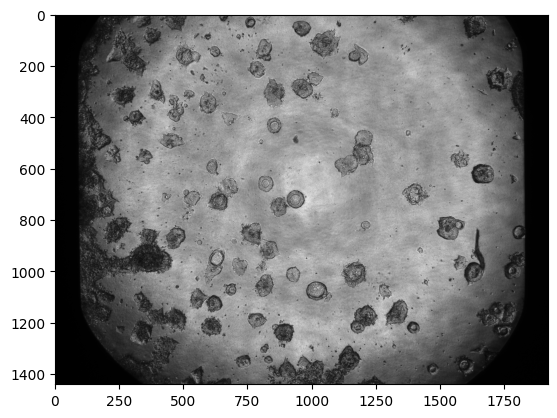

Image: ../dataset/complete_dataset/images/D284_DMSO_d9/DMSO/4x_XY195_Z001_CH4.tif,
CTG: 0.8274683061966406,
GT area: 0.27456711640623266,
diff: 0.5529011897904079,
predicted area: 0.4011414396440615


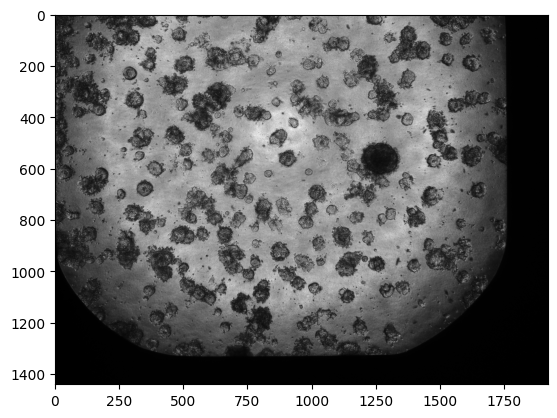

Image: ../dataset/complete_dataset/images/D223_CTRL_d9/Intermediate_response/4x_XY376_Z001_CH4.tif,
CTG: 0.6318472518305682,
GT area: 0.0794638689457423,
diff: 0.5523833828848259,
predicted area: 0.10939900068857147


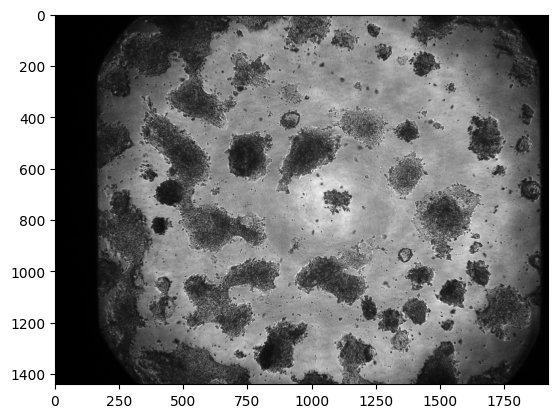

Image: ../dataset/complete_dataset/images/D223_CTRL_d9/DMSO/4x_XY36_Z001_CH4.tif,
CTG: 0.44944954222922523,
GT area: 1.0,
diff: 0.5505504577707747,
predicted area: 1.0


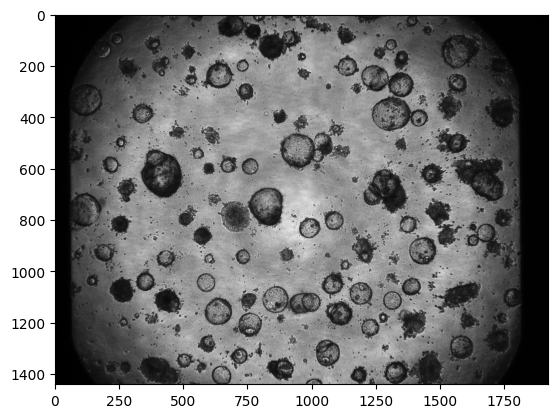

Image: ../dataset/complete_dataset/images/D284_DMSO_d9/Intermediate_response/4x_XY108_Z001_CH4.tif,
CTG: 0.8872617171810795,
GT area: 0.355164595790082,
diff: 0.5320971213909975,
predicted area: 0.23555544765973976


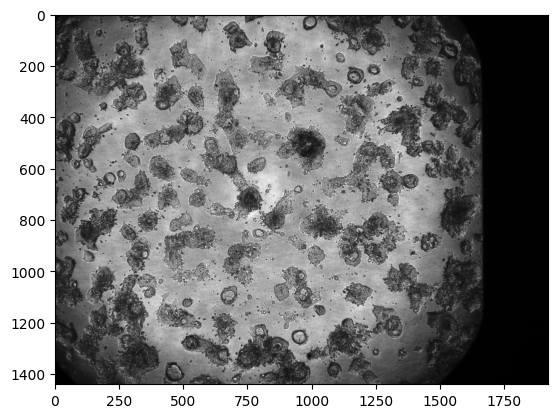

Image: ../dataset/complete_dataset/images/D284_DMSO_d9/Intermediate_response/4x_XY134_Z001_CH4.tif,
CTG: 0.8459027198484053,
GT area: 0.33383271466358444,
diff: 0.5120700051848208,
predicted area: 0.38136707922103147


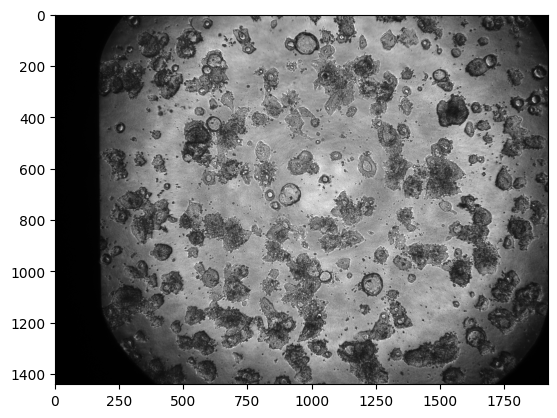

Image: ../dataset/complete_dataset/images/D284_DMSO_d9/Bortezomib/4x_XY183_Z001_CH4.tif,
CTG: 0.510447884161852,
GT area: 0.012445264397963948,
diff: 0.4980026197638881,
predicted area: 0.010845000794505552


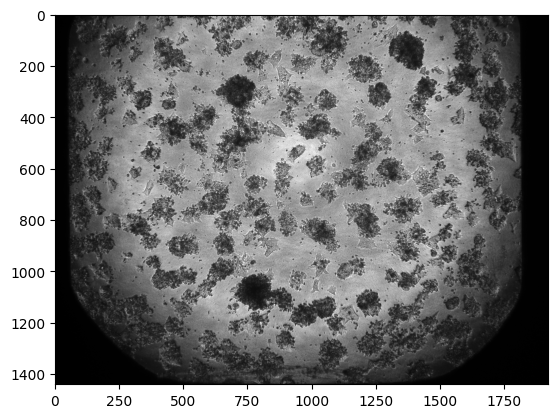

Image: ../dataset/complete_dataset/images/D284_DMSO_d9/Intermediate_response/4x_XY75_Z001_CH4.tif,
CTG: 0.5968733586677789,
GT area: 0.12498388494965436,
diff: 0.47188947371812456,
predicted area: 0.09693850527022016


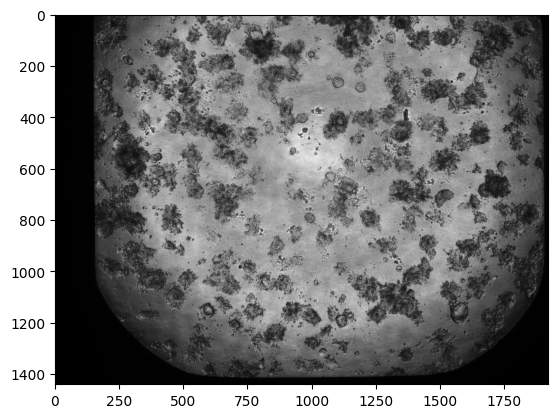

Image: ../dataset/complete_dataset/images/D223_CTRL_d9/DMSO/4x_XY287_Z001_CH4.tif,
CTG: 0.453177619180029,
GT area: 0.9238524972771122,
diff: 0.47067487809708314,
predicted area: 0.9393681915288052


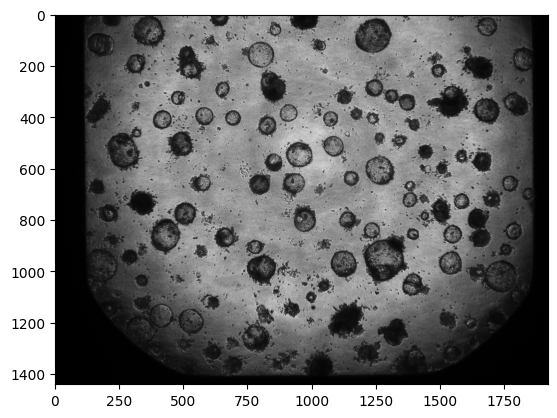

Image: ../dataset/complete_dataset/images/D223_CTRL_d9/Intermediate_response/4x_XY33_Z001_CH4.tif,
CTG: 0.6423620766006529,
GT area: 0.17407810798195114,
diff: 0.4682839686187018,
predicted area: 0.2011754268260386


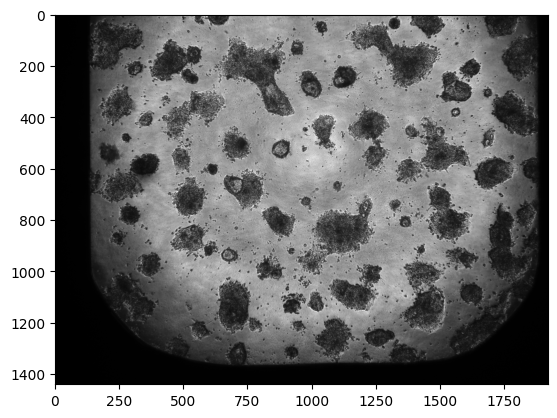

In [ ]:
# look at differences
df = processed_predictions_finetuned[0.9]
print(df.columns)
pd.set_option('display.max_colwidth', None)
df["diff_gt"] = abs(df["CTG_norm"] - df["gt_area_norm"])
df["diff_pred"] = abs(df["CTG_norm"] - df["predicted_area_norm"])

print("### Images in ascending order of difference between CTG and ground truth area ###")
df.sort_values(by=["diff_gt"], ascending=False, inplace=True)
i = 0
for id, row in df.sort_values(by=["diff_gt"], ascending=False).iterrows():
    i += 1
    print(f"Image: {row['image_path']},\nCTG: {row['CTG_norm']},\nGT area: {row['gt_area_norm']},\ndiff: {row['diff_gt']},\npredicted area: {row['predicted_area_norm']}")
    image = cv2.imread(row["image_path"])
    plt.imshow(image)
    plt.show()
    if i == 2:
        break